# Average LST and Average NDVI across Regions in Singapore

- Spatial plots for mean LST and mean NDVI across all regions in Singapore
- Bar plots for mean LST and mean NDVI across HDB Towns in Singapore (for 2024)
- Mean LST plots for specific regions over time (no clear increase in LST)

In [ ]:
import geopandas as gpd
import pandas as pd
import hvplot.pandas
import numpy as np
import os
import zipfile
from datetime import datetime
import logging
import shutil
import rasterio
import numpy as np
from pyproj import Transformer
from shapely.geometry import Point
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

## 2023-10-13

In [4]:
# Suppress FutureWarnings

warnings.simplefilter(action='ignore', category=FutureWarning)

singapore_geojson_path = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\singapore-boundary.geojson"
regions_geojson_path = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\sg-planning-area.geojson"

year = "2023"

# Suppress other warnings and logging
logging.getLogger('bokeh').setLevel(logging.ERROR)
pd.options.mode.chained_assignment = None  # Suppress specific pandas warnings

zip_file_path = f"C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\Landsat8\\{year}.zip"
temp_dir = f"C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\temp_extract"

os.makedirs(temp_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

gdfs = []

for filename in os.listdir(f"{temp_dir}\\{year}"):
    if filename.endswith("20231013_031648.tif"):
        print("Currently processing: " + filename)
        file_path = os.path.join(f"{temp_dir}\\{year}", filename)
        time_str = filename.split('_')[2]
        time_obj = datetime.strptime(time_str, "%Y%m%d")

        gdf = preprocessing_sg_regions(file_path, singapore_geojson_path, regions_geojson_path)
        gdf['time'] = time_obj
        gdfs.append(gdf)

combined_gdf = pd.concat(gdfs)

shutil.rmtree(temp_dir)

print(combined_gdf)

Currently processing: L8_UTC_20231013_031648.tif
Total number of valid pixels within Singapore: 678275
          Longitude  Latitude   SR_B1   SR_B2    SR_B3    SR_B4    SR_B5  \
2585     103.806257  1.469955  8323.0  9025.0  10316.0  10506.0  13248.0   
2586     103.806526  1.469955  8370.0  9115.0  10326.0  10589.0  14151.0   
2587     103.806796  1.469955  8493.0  9175.0  10830.0  11197.0  14639.0   
2588     103.807065  1.469955  8475.0  9220.0  10836.0  11217.0  13081.0   
2589     103.807335  1.469955  8498.0  9308.0  10960.0  11526.0  14659.0   
...             ...       ...     ...     ...      ...      ...      ...   
1692025  103.834420  1.212719  7388.0  7964.0   9174.0   8339.0  12126.0   
1692026  103.834690  1.212719  7146.0  7777.0   9034.0   8484.0  16402.0   
1693807  103.834420  1.212448  7596.0  8176.0   9361.0   8712.0  13082.0   
1693808  103.834690  1.212448  7487.0  8069.0   9200.0   8639.0  13907.0   
1693809  103.834959  1.212448  7678.0  8331.0   9443.0   8578

In [8]:
combined_gdf['ST_B10_Celsius'] = combined_gdf['ST_B10']  * 0.00341802 + 149 - 273.15
combined_gdf['NDVI'] = (combined_gdf['SR_B5'] - combined_gdf['SR_B4']) / (combined_gdf['SR_B5'] + combined_gdf['SR_B4'])

# Convert 'time' to datetime if it's not already
combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])

# Define the filtering values
qa_pixel_filter_1 = [5504, 22280, 5896, 7440, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56916]
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

# Filter out unwanted 'QA_PIXEL' values
filtered_gdf = combined_gdf[~combined_gdf['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Further filter out unwanted 'SR_QA_AEROSOL' values
filtered_gdf = filtered_gdf[~filtered_gdf['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

In [9]:
mean_lst_by_region = filtered_gdf.groupby('region')['ST_B10_Celsius'].mean().reset_index()
mean_ndvi_by_region = filtered_gdf.groupby('region')['NDVI'].mean().reset_index()

In [11]:
combined_data = pd.merge(mean_ndvi_by_region, mean_lst_by_region, on='region')

### Scatter Plot and Correlation Analysis of Average LST and Average NDVI

In [ ]:
# Merge the NDVI and LST dataframes on region
combined_data = pd.merge(mean_ndvi_by_region, mean_lst_by_region, on='region')

In [123]:
combined_data

,region,NDVI,ST_B10_Celsius
0,ANG MO KIO,0.300158,38.173069
1,BEDOK,0.191125,40.655376
2,BISHAN,0.240897,39.143356
3,BOON LAY,0.150430,40.501240
4,BUKIT BATOK,0.328396,36.460289
5,BUKIT MERAH,0.302520,36.174881
6,BUKIT PANJANG,0.329339,35.292042
7,BUKIT TIMAH,0.289416,38.589504
8,CENTRAL WATER CATCHMENT,0.371007,33.751076
9,CHANGI,0.191615,38.641312


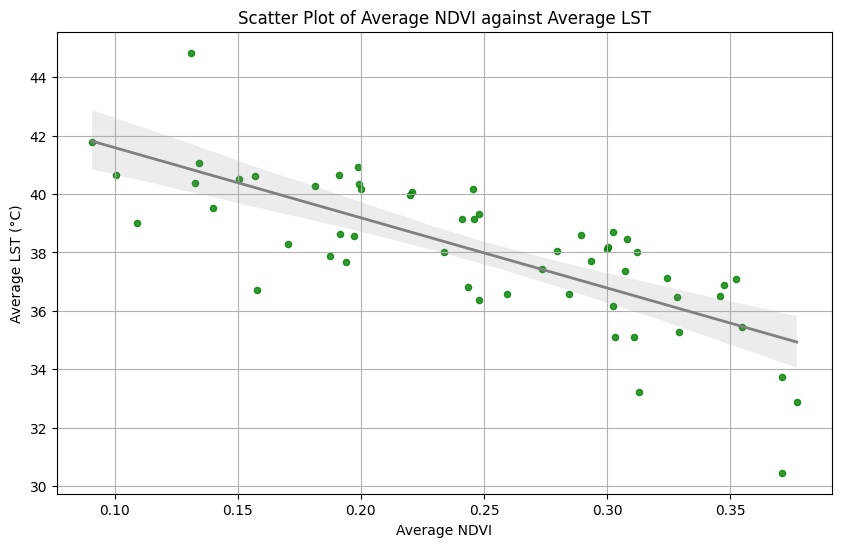

In [86]:
plt.figure(figsize=(10, 6))
sns.regplot(x='NDVI', y='ST_B10_Celsius', data=combined_data, scatter_kws={'s': 20, 'color' : 'green'}, line_kws={"color": "grey", "lw": 2})
plt.title('Scatter Plot of Average NDVI against Average LST')
plt.xlabel('Average NDVI')
plt.ylabel('Average LST (°C)')
plt.grid(True)
plt.show()

In [77]:
# Correlation analysis
correlation_coefficient, p_value = pearsonr(combined_data['NDVI'], combined_data['ST_B10_Celsius'])
print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

Pearson correlation coefficient: -0.7611485007126049
P-value: 1.5300540954723862e-11


### Spatial Plot of Average LST and Average NDVI

In [15]:
# Path to the GeoJSON file
geojson_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\sg-planning-area.geojson"

# Read the GeoJSON file using Geopandas
gdf = gpd.read_file(geojson_path)

# # Save the DataFrame to CSV
# csv_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\sg-planning-area.csv"
# gdf.to_csv(csv_path, index=False)

# print(f"Data has been successfully saved to {csv_path}")

In [89]:
print(gdf)

                       name                                           geometry
0                    BISHAN  POLYGON ((103.84924 1.36275, 103.84936 1.36268...
1               BUKIT BATOK  POLYGON ((103.76408 1.37001, 103.76444 1.36947...
2               BUKIT MERAH  POLYGON ((103.81740 1.29433, 103.81743 1.29431...
3             BUKIT PANJANG  POLYGON ((103.77445 1.39029, 103.77499 1.38607...
4               BUKIT TIMAH  POLYGON ((103.79766 1.34813, 103.79806 1.34779...
5   CENTRAL WATER CATCHMENT  POLYGON ((103.80702 1.41126, 103.80754 1.40986...
6                    CHANGI  POLYGON ((103.98236 1.39356, 103.98242 1.39349...
7                CHANGI BAY  MULTIPOLYGON (((104.02076 1.32566, 104.02139 1...
8             CHOA CHU KANG  POLYGON ((103.74660 1.40541, 103.74691 1.40540...
9                  CLEMENTI  POLYGON ((103.75857 1.29929, 103.75831 1.29911...
10                  GEYLANG  POLYGON ((103.90179 1.30975, 103.90150 1.30954...
11                   NOVENA  POLYGON ((103.83599 1.3

In [16]:
# Renaming GDF's 'name' column
gdf = gdf.rename(columns={'name': 'region'})

# Merging GeoJSON and `combined_gdf` of Average LST and Average NDVI across regions
merged_gdf = gdf.merge(combined_data, on='region')

In [26]:
# AVERAGE LST PLOT

# Plot using hvPlot with polygons colored by average LST
avg_LST_plot = merged_gdf.hvplot(
    geo=True,  # Enable geographic contextual rendering
    c='ST_B10_Celsius',  # Column to color by
    cmap='oranges',  # Color map
    tiles='OSM',
    hover_cols=['region', 'ST_B10_Celsius'],  # Data to show on hover
    title='Average LST by Region',
    width=700,
    height=500,
    line_color='white',
    alpha=0.85
)

# Display the plot
avg_LST_plot

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (ST_B10_Celsius,region)

In [29]:
# AVERAGE NDVI PLOT

# Plot using hvPlot with polygons colored by average LST
avg_NDVI_plot = merged_gdf.hvplot(
    geo=True,  # Enable geographic contextual rendering
    c='NDVI',  # Column to color by
    cmap='greens',  # Color map
    tiles='OSM',
    hover_cols=['region', 'NDVI'],  # Data to show on hover
    title='Average NDVI by Region',
    width=700,
    height=500,
    line_color='black',
    alpha=0.85
)

# Display the plot
avg_NDVI_plot

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (NDVI,region)

# Analysis for HDB Towns

In [3]:
def preprocessing_sg_hdb_regions(file_path, singapore_geojson_path, regions_geojson_path):
    # Open your GeoTIFF file
    with rasterio.open(file_path) as src:
        array = src.read()
        transform = src.transform
        src_crs = src.crs  # Source CRS

        # Create a transformer object to convert from src_crs to EPSG:4326 (WGS 84)
        transformer = Transformer.from_crs(src_crs, 'EPSG:4326', always_xy=True)

        # Get arrays of column and row indices
        cols, rows = np.meshgrid(np.arange(array.shape[2]), np.arange(array.shape[1]))

        # Convert meshgrid arrays to coordinate arrays using rasterio's method, which are 2D
        xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

        # Flatten the coordinate arrays to pass to transform function
        lon, lat = transformer.transform(np.array(xs).flatten(), np.array(ys).flatten())

        # Create DataFrame and convert to GeoDataFrame
        df = pd.DataFrame({'Longitude': lon, 'Latitude': lat})
        for i, band in enumerate(src.read(masked=True)):
            df[src.descriptions[i]] = band.flatten()

        # Filter rows where temperature is relevant, assuming a threshold
        df_filtered = df[df['ST_B10'] * 0.00341802 + 149 - 273.15 >= 20]

        # Create a GeoDataFrame from the filtered DataFrame
        gdf = gpd.GeoDataFrame(df_filtered, geometry=gpd.points_from_xy(df_filtered.Longitude, df_filtered.Latitude))
        gdf.set_crs('EPSG:4326', inplace=True)

        # Read the Singapore boundary and regions GeoJSON
        singapore = gpd.read_file(singapore_geojson_path)
        regions = gpd.read_file(regions_geojson_path)

        # Convert CRS of regions to match the GeoDataFrame
        regions = regions.to_crs('EPSG:4326')

        # Spatial join to filter and categorize by region
        gdf = gdf.sjoin(singapore, how='inner', op='intersects', lsuffix='_left', rsuffix='_right')
        gdf = gdf.sjoin(regions, how='inner', op='intersects', lsuffix='_left1', rsuffix='_right1')

        # Adding a 'region' column that tags each pixel to its respective region
        gdf['region'] = gdf['NME_BNDRY']  # Assuming 'name' is the column in regions GeoJSON that contains region names

        # Print the total number of valid pixels within Singapore
        print("Total number of valid pixels within Singapore: " + str(len(gdf)))

    return gdf

In [122]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

singapore_geojson_path = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\singapore-boundary.geojson"
HDB_estates_geojson_path = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\HDB_TownEstate_P.geojson"

year = "2024"

# Suppress other warnings and logging
logging.getLogger('bokeh').setLevel(logging.ERROR)
pd.options.mode.chained_assignment = None  # Suppress specific pandas warnings

zip_file_path = f"C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\Landsat9\\{year}.zip"
temp_dir = f"C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\temp_extract"

os.makedirs(temp_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

gdfs = []

for filename in os.listdir(f"{temp_dir}\\{year}"):
    if filename.endswith(".tif"):
        print("Currently processing: " + filename)
        file_path = os.path.join(f"{temp_dir}\\{year}", filename)
        time_str = filename.split('_')[2]
        time_obj = datetime.strptime(time_str, "%Y%m%d")

        gdf = preprocessing_sg_regions(file_path, singapore_geojson_path, HDB_estates_geojson_path)
        gdf['time'] = time_obj
        gdfs.append(gdf)

combined_gdf = pd.concat(gdfs)

shutil.rmtree(temp_dir)

print(combined_gdf)

Currently processing: L9_UTC_20240109_031653.tif
Total number of valid pixels within Singapore: 26
Currently processing: L9_UTC_20240125_031651.tif
Total number of valid pixels within Singapore: 104939
Currently processing: L9_UTC_20240210_031656.tif
Total number of valid pixels within Singapore: 0
Currently processing: L9_UTC_20240226_031644.tif
Total number of valid pixels within Singapore: 1305
Currently processing: L9_UTC_20240313_031647.tif
Total number of valid pixels within Singapore: 188293
Currently processing: L9_UTC_20240329_031638.tif
Total number of valid pixels within Singapore: 154021
Currently processing: L9_UTC_20240430_031614.tif
Total number of valid pixels within Singapore: 6763
Currently processing: L9_UTC_20240516_031607.tif
Total number of valid pixels within Singapore: 0
         Longitude  Latitude    SR_B1    SR_B2    SR_B3    SR_B4    SR_B5  \
743968  103.825457  1.357079  10294.0  10181.0  12317.0  12197.0  19303.0   
743969  103.825727  1.357079  10485.0  1

In [124]:
combined_gdf['ST_B10_Celsius'] = combined_gdf['ST_B10'] * 0.00341802 + 149 - 273.15

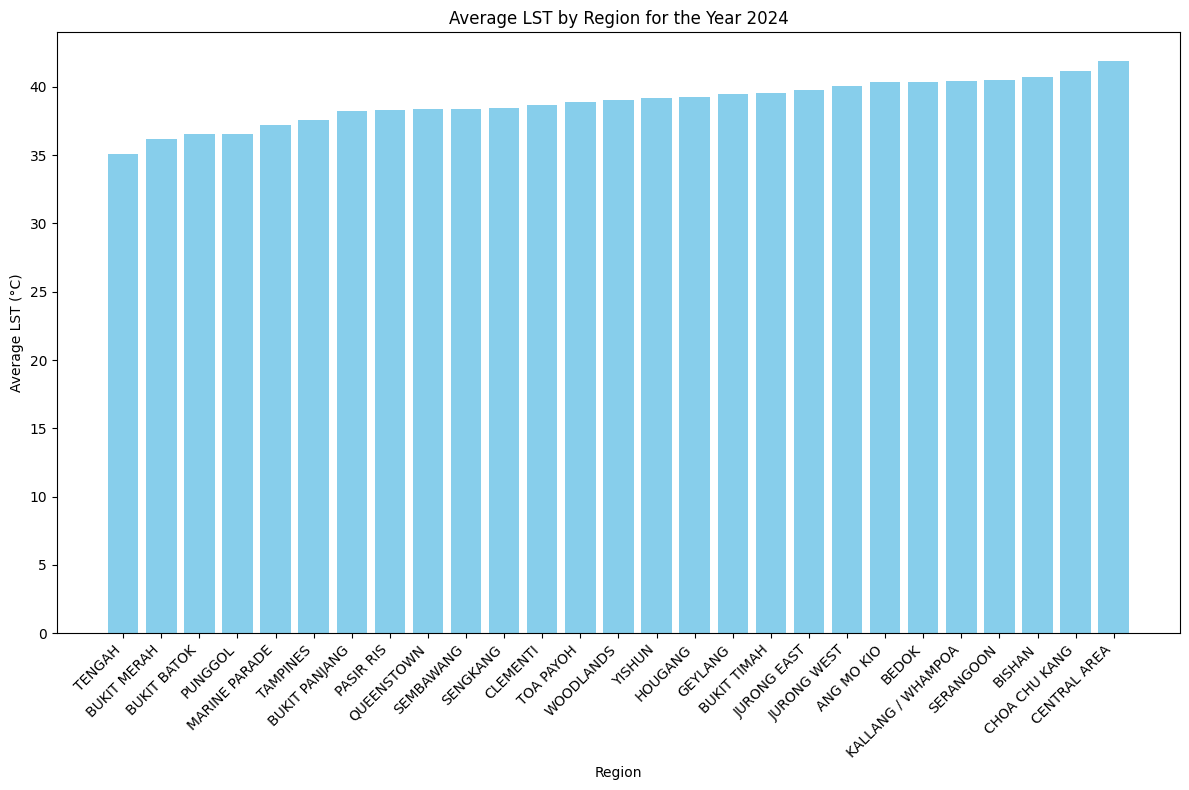

In [125]:
# Regions across Singapore sorted by average LST for the year 2024 
# Convert 'time' to datetime if it's not already
combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])

# Define the filtering values
qa_pixel_filter_1 = [5504, 22280, 5896, 7440, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56916]
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

# Filter out unwanted 'QA_PIXEL' values
filtered_gdf = combined_gdf[~combined_gdf['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Further filter out unwanted 'SR_QA_AEROSOL' values
filtered_gdf = filtered_gdf[~filtered_gdf['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

# Ensure to filter the data within the specific year, if necessary (example for the entire year of 2024)
year_filtered_gdf = filtered_gdf[filtered_gdf['time'].dt.year == 2024]

# Check if any data is present for the year
if year_filtered_gdf.empty:
    print("No data available for the year 2024.")
else:
    # Calculate mean LST for each region
    mean_lst_by_region = year_filtered_gdf.groupby('region')['ST_B10_Celsius'].mean().reset_index()

    # Sort the DataFrame by LST in ascending order
    mean_lst_by_region = mean_lst_by_region.sort_values('ST_B10_Celsius')
    
    # Plotting the results
    plt.figure(figsize=(12, 8))
    plt.bar(mean_lst_by_region['region'], mean_lst_by_region['ST_B10_Celsius'], color='skyblue')
    plt.xlabel('Region')
    plt.ylabel('Average LST (°C)')
    plt.title('Average LST by Region for the Year 2024')
    plt.xticks(rotation=45, ha="right")  # Rotate region names for better readability
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()

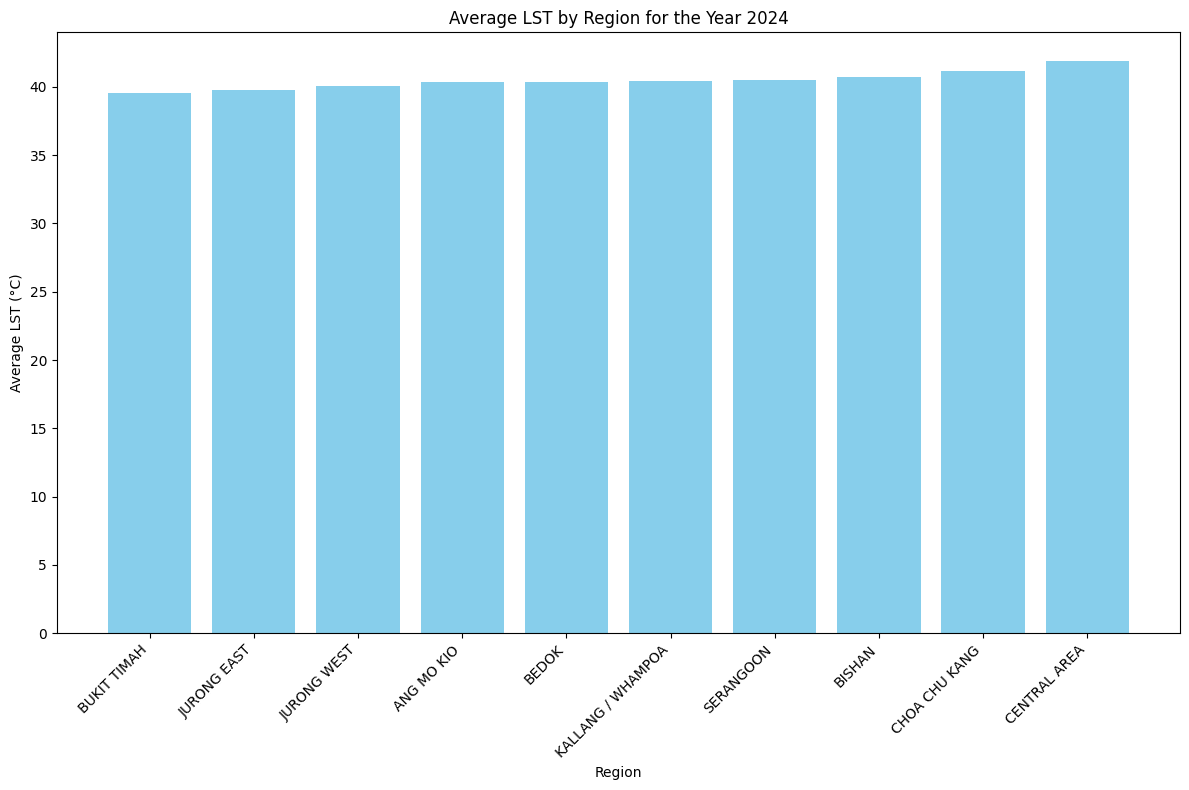

In [126]:
# TOP 10 regions across Singapore sorted by average LST for the year 2024 
# Convert 'time' to datetime if it's not already
combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])

# Define the filtering values
qa_pixel_filter_1 = [5504, 22280, 5896, 7440, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56916]
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

# Filter out unwanted 'QA_PIXEL' values
filtered_gdf = combined_gdf[~combined_gdf['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Further filter out unwanted 'SR_QA_AEROSOL' values
filtered_gdf = filtered_gdf[~filtered_gdf['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

# Ensure to filter the data within the specific year, if necessary (example for the entire year of 2024)
year_filtered_gdf = filtered_gdf[filtered_gdf['time'].dt.year == 2024]

# Check if any data is present for the year
if year_filtered_gdf.empty:
    print("No data available for the year 2024.")
else:
    # Calculate mean LST for each region
    mean_lst_by_region = year_filtered_gdf.groupby('region')['ST_B10_Celsius'].mean().reset_index()

    # Sort the DataFrame by LST in ascending order
    mean_lst_by_region_top_10 = mean_lst_by_region.sort_values('ST_B10_Celsius').tail(10)
    
    # Plotting the results
    plt.figure(figsize=(12, 8))
    plt.bar(mean_lst_by_region_top_10['region'], mean_lst_by_region_top_10['ST_B10_Celsius'], color='skyblue')
    plt.xlabel('Region')
    plt.ylabel('Average LST (°C)')
    plt.title('Average LST by Region for the Year 2024')
    plt.xticks(rotation=45, ha="right")  # Rotate region names for better readability
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()

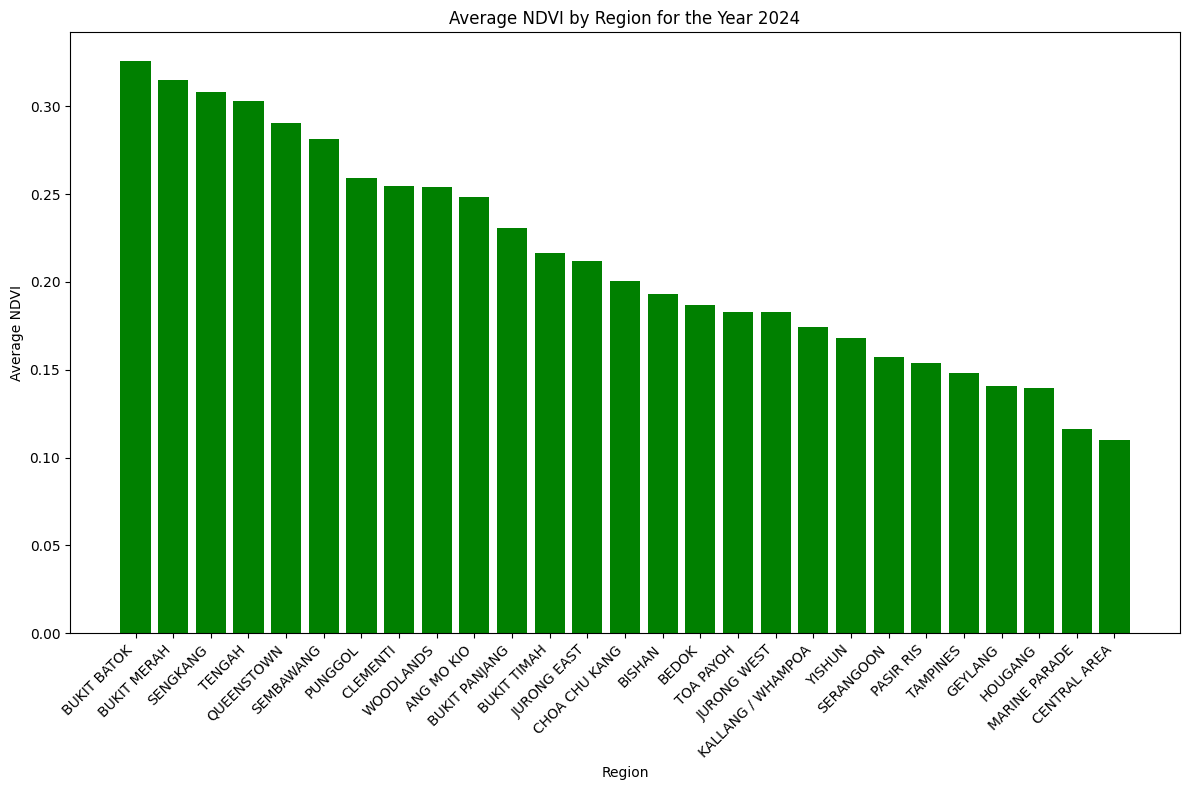

In [127]:
# Regions across Singapore sorted by average NDVI in descending order for the year 2024 

year_filtered_gdf['NDVI'] = (year_filtered_gdf['SR_B5'] - year_filtered_gdf['SR_B4']) / (year_filtered_gdf['SR_B5'] + year_filtered_gdf['SR_B4'])

# Check if any data is present for the year
if year_filtered_gdf.empty:
    print("No data available for the year 2024.")
else:
    # Calculate mean NDVI for each region
    mean_ndvi_by_region = year_filtered_gdf.groupby('region')['NDVI'].mean().reset_index()

    # Sort the DataFrame by NDVI in ascending order
    mean_ndvi_by_region = mean_ndvi_by_region.sort_values('NDVI', ascending=False)
    
    # Plotting the results
    plt.figure(figsize=(12, 8))
    plt.bar(mean_ndvi_by_region['region'], mean_ndvi_by_region['NDVI'], color='green')
    plt.xlabel('Region')
    plt.ylabel('Average NDVI')
    plt.title('Average NDVI by Region for the Year 2024')
    plt.xticks(rotation=45, ha="right")  # Rotate region names for better readability
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()

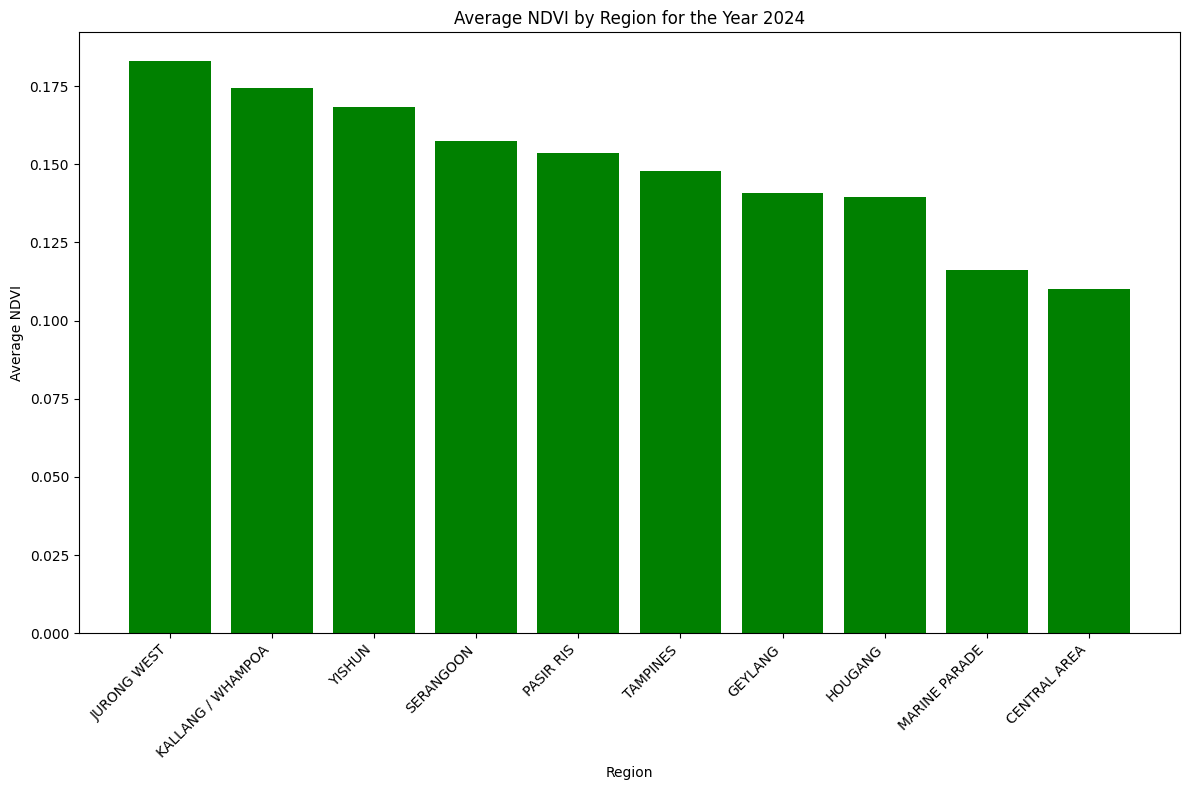

In [128]:
# TOP 10 regions across Singapore sorted by average NDVI in descending order for the year 2024 

year_filtered_gdf['NDVI'] = (year_filtered_gdf['SR_B5'] - year_filtered_gdf['SR_B4']) / (year_filtered_gdf['SR_B5'] + year_filtered_gdf['SR_B4'])

# Check if any data is present for the year
if year_filtered_gdf.empty:
    print("No data available for the year 2024.")
else:
    # Calculate mean NDVI for each region
    mean_ndvi_by_region = year_filtered_gdf.groupby('region')['NDVI'].mean().reset_index()

    # Sort the DataFrame by NDVI in ascending order
    mean_ndvi_by_region_top_10 = mean_ndvi_by_region.sort_values('NDVI', ascending=False).tail(10)
    
    # Plotting the results
    plt.figure(figsize=(12, 8))
    plt.bar(mean_ndvi_by_region_top_10['region'], mean_ndvi_by_region_top_10['NDVI'], color='green')
    plt.xlabel('Region')
    plt.ylabel('Average NDVI')
    plt.title('Average NDVI by Region for the Year 2024')
    plt.xticks(rotation=45, ha="right")  # Rotate region names for better readability
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()

In [132]:
# Assuming mean_lst_by_region and mean_ndvi_by_region are already defined
# and both contain a column named 'region' with the names of the regions.

# Convert the 'region' columns from both dataframes to sets
mean_lst_by_region_top_10_set = set(mean_lst_by_region_top_10['region'])
mean_ndvi_by_region_top_10_set = set(mean_ndvi_by_region_top_10['region'])

# Find the intersection of both sets
intersecting_regions = mean_lst_by_region_top_10_set.intersection(mean_ndvi_by_region_top_10_set)

# Print the intersecting region names
print("Intersecting Regions:")
for region in intersecting_regions:
    print(region)

print(f"\n{len(intersecting_regions)} of the top 10 regions with highest average LST have also have the lowest NDVI in Singapore")

Intersecting Regions:
KALLANG / WHAMPOA
JURONG WEST
CENTRAL AREA
SERANGOON

4 of the top 10 regions with highest average LST have also have the lowest NDVI in Singapore


### Scatter Plot and Correlation Analysis of Average LST and Average NDVI

In [133]:
# Merge the NDVI and LST dataframes on region
combined_data = pd.merge(mean_ndvi_by_region, mean_lst_by_region, on='region')

In [134]:
combined_data

,region,NDVI,ST_B10_Celsius
0,ANG MO KIO,0.248277,40.329632
1,BEDOK,0.186631,40.333759
2,BISHAN,0.193328,40.696789
3,BUKIT BATOK,0.325801,36.546009
4,BUKIT MERAH,0.315123,36.196461
5,BUKIT PANJANG,0.230446,38.230423
6,BUKIT TIMAH,0.216452,39.532303
7,CENTRAL AREA,0.110008,41.900677
8,CHOA CHU KANG,0.200720,41.153976
9,CLEMENTI,0.254846,38.707375


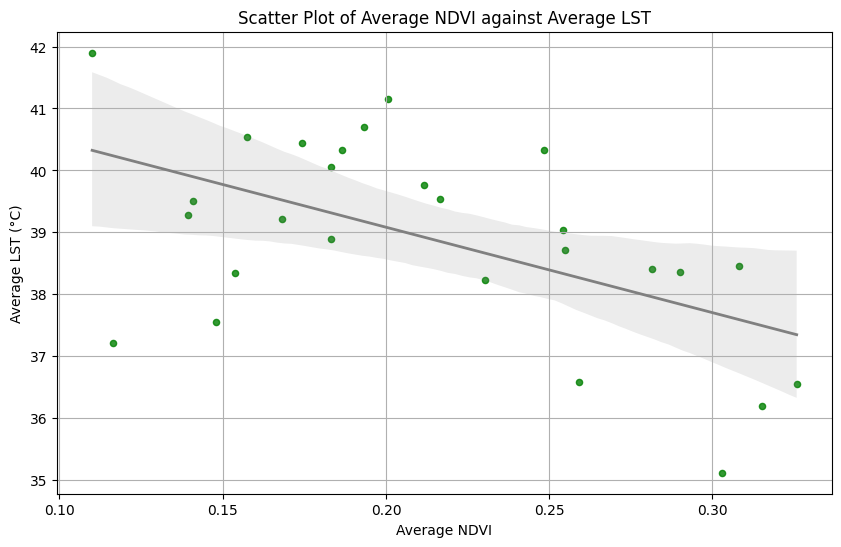

In [135]:
plt.figure(figsize=(10, 6))
sns.regplot(x='NDVI', y='ST_B10_Celsius', data=combined_data, scatter_kws={'s': 20, 'color' : 'green'}, line_kws={"color": "grey", "lw": 2})
plt.title('Scatter Plot of Average NDVI against Average LST')
plt.xlabel('Average NDVI')
plt.ylabel('Average LST (°C)')
plt.grid(True)
plt.show()

In [136]:
# Correlation analysis
correlation_coefficient, p_value = pearsonr(combined_data['NDVI'], combined_data['ST_B10_Celsius'])
print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

Pearson correlation coefficient: -0.5437232110020483
P-value: 0.00337434674536511


### Spatial Plot of Average LST and Average NDVI

In [1]:
# Path to the GeoJSON file
geojson_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\HDB_TownEstate_P.geojson"

# Read the GeoJSON file using Geopandas
gdf = gpd.read_file(geojson_path)

# # Save the DataFrame to CSV
# csv_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\sg-planning-area.csv"
# gdf.to_csv(csv_path, index=False)

# print(f"Data has been successfully saved to {csv_path}")

In [139]:
print(gdf)

    OBJECTID          NME_BNDRY           INC_CRC      FMEL_UPD_D  \
0       1284             TENGAH  84774D140145C8DA  20201007153219   
1       1281         ANG MO KIO  9C5CBD0F78C61BEB  20231101120746   
2       1282        BUKIT TIMAH  68B79B0115DBBD0D  20211019141748   
3       1283           TAMPINES  D3B7B9DB1993C0EF  20201007153219   
4       1285          TOA PAYOH  12F03406F3176DEE  20201007153219   
5       1286            HOUGANG  D38E5B7A01CA427C  20201007153219   
6       1288      CHOA CHU KANG  347FCD08E1D4313A  20201007153219   
7       1289        JURONG EAST  6DEF5BDEF9528E1E  20201007153219   
8       1287           SENGKANG  5EA918FB8336FB9D  20201007153219   
9       1290          SEMBAWANG  8F906E00AAFB6F5F  20201007153219   
10      1291              BEDOK  11D22FE0A4F6000C  20231101120746   
11      1292  KALLANG / WHAMPOA  B72425ED025C3E8C  20231101120746   
12      1293            GEYLANG  F074C206E54ACE0B  20231101120746   
13      1294         QUEENSTOWN  2

In [2]:
# Renaming GDF's 'name' column
gdf = gdf.rename(columns={'NME_BNDRY': 'region'})

# Merging GeoJSON and `combined_gdf` of Average LST and Average NDVI across regions
merged_gdf = gdf.merge(combined_data, on='region')

NameError: name 'combined_data' is not defined

## Average LST and Average NDVI for specific regions across time (Downtown Core, Punggol, Pioneer, Serangoon, Marine Parade, Geylang)

In [150]:
def preprocessing_sg_regions_landsat5(file_path, singapore_geojson_path, regions_geojson_path):
    # Open your GeoTIFF file
    with rasterio.open(file_path) as src:
        array = src.read()
        transform = src.transform
        src_crs = src.crs  # Source CRS

        # Create a transformer object to convert from src_crs to EPSG:4326 (WGS 84)
        transformer = Transformer.from_crs(src_crs, 'EPSG:4326', always_xy=True)

        # Get arrays of column and row indices
        cols, rows = np.meshgrid(np.arange(array.shape[2]), np.arange(array.shape[1]))

        # Convert meshgrid arrays to coordinate arrays using rasterio's method, which are 2D
        xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

        # Flatten the coordinate arrays to pass to transform function
        lon, lat = transformer.transform(np.array(xs).flatten(), np.array(ys).flatten())

        # Create DataFrame and convert to GeoDataFrame
        df = pd.DataFrame({'Longitude': lon, 'Latitude': lat})
        for i, band in enumerate(src.read(masked=True)):
            df[src.descriptions[i]] = band.flatten()

        # Filter rows where temperature is relevant, assuming a threshold
        df_filtered = df[df['ST_B6'] * 0.00341802 + 149 - 273.15 >= 20]

        # Create a GeoDataFrame from the filtered DataFrame
        gdf = gpd.GeoDataFrame(df_filtered, geometry=gpd.points_from_xy(df_filtered.Longitude, df_filtered.Latitude))
        gdf.set_crs('EPSG:4326', inplace=True)

        # Read the Singapore boundary and regions GeoJSON
        singapore = gpd.read_file(singapore_geojson_path)
        regions = gpd.read_file(regions_geojson_path)

        # Convert CRS of regions to match the GeoDataFrame
        regions = regions.to_crs('EPSG:4326')

        # Spatial join to filter and categorize by region
        gdf = gdf.sjoin(singapore, how='inner', op='intersects', lsuffix='_left', rsuffix='_right')
        gdf = gdf.sjoin(regions, how='inner', op='intersects', lsuffix='_left1', rsuffix='_right1')

        # Adding a 'region' column that tags each pixel to its respective region
        gdf['region'] = gdf['name']  # Assuming 'name' is the column in regions GeoJSON that contains region names

        # Print the total number of valid pixels within Singapore
        print("Total number of valid pixels within Singapore: " + str(len(gdf)))

    return gdf

In [151]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

singapore_geojson_path = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\singapore-boundary.geojson"
regions_geojson_path = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\sg-planning-area.geojson"

# Suppress other warnings and logging
logging.getLogger('bokeh').setLevel(logging.ERROR)
pd.options.mode.chained_assignment = None

gdfs = []

# Loop through each year from 1990 to 2011
for year in range(1990, 2012):
    if year == 2002:
        continue  # Skip the year 2002

    zip_file_path = f"C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\Landsat5\\{year}.zip"
    temp_dir = f"C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\temp_extract_{year}"  # Unique temp directory for each year

    os.makedirs(temp_dir, exist_ok=True)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    for filename in os.listdir(f"{temp_dir}\\{year}"):
        if filename.endswith(".tif"):
            print(f"Currently processing: {filename} for year {year}")
            file_path = os.path.join(f"{temp_dir}\\{year}", filename)
            time_str = filename.split('_')[2]
            time_obj = datetime.strptime(time_str, "%Y%m%d")

            gdf = preprocessing_sg_regions_landsat5(file_path, singapore_geojson_path, regions_geojson_path)
            gdf['time'] = time_obj
            gdfs.append(gdf)

    shutil.rmtree(temp_dir)

# Concatenate all GeoDataFrames collected over the years
landsat5_combined_gdf = pd.concat(gdfs)

print(landsat5_combined_gdf)

Currently processing: L5_UTC_19900103_023927.tif for year 1990
Total number of valid pixels within Singapore: 632166
Currently processing: L5_UTC_19900220_023759.tif for year 1990
Total number of valid pixels within Singapore: 334330
Currently processing: L5_UTC_19900308_023724.tif for year 1990
Total number of valid pixels within Singapore: 57810
Currently processing: L5_UTC_19900409_023646.tif for year 1990
Total number of valid pixels within Singapore: 578696
Currently processing: L5_UTC_19900511_023652.tif for year 1990
Total number of valid pixels within Singapore: 600088
Currently processing: L5_UTC_19900527_023648.tif for year 1990
Total number of valid pixels within Singapore: 303235
Currently processing: L5_UTC_19900612_023648.tif for year 1990
Total number of valid pixels within Singapore: 21839
Currently processing: L5_UTC_19900628_023647.tif for year 1990
Total number of valid pixels within Singapore: 168648
Currently processing: L5_UTC_19900714_023644.tif for year 1990
Tot

In [152]:
landsat5_combined_gdf.columns

Index(['Longitude', 'Latitude', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5',
       'SR_B7', 'SR_ATMOS_OPACITY', 'SR_CLOUD_QA', 'ST_B6', 'ST_ATRAN',
       'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD',
       'ST_URAD', 'QA_PIXEL', 'QA_RADSAT', 'geometry', 'index__right',
       'index__right1', 'name', 'region', 'time'],
      dtype='object')

In [153]:
# Filtering by pixel level quality
# Define the QA_PIXEL values to filter out
qa_pixel_filter_1 = [5504, 22280, 5896, 7440, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56916]

# Step 1: Filter out pixels based on QA_PIXEL values
filtered_gdf = landsat5_combined_gdf[~landsat5_combined_gdf['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Step 2: Convert ST_B6 to Celsius and create a new column
filtered_gdf['ST_B6_Celsius'] = filtered_gdf['ST_B6'] * 0.00341802 + 149 - 273.15

# Step 3: Calculate NDVI
filtered_gdf['NDVI'] = (filtered_gdf['SR_B5'] - filtered_gdf['SR_B4']) / (filtered_gdf['SR_B5'] + filtered_gdf['SR_B4'])

In [158]:
filtered_gdf['region'].head()

2589    SEMBAWANG
2590    SEMBAWANG
2591    SEMBAWANG
2592    SEMBAWANG
2593    SEMBAWANG
Name: region, dtype: object

#### `region` == DOWNTOWN CORE

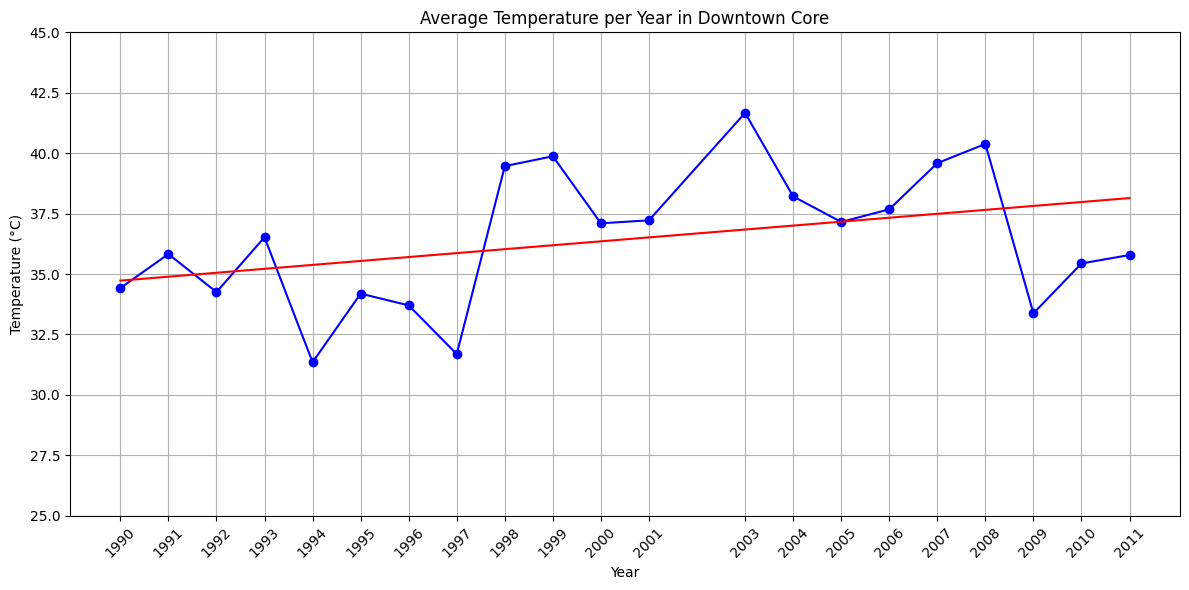

In [170]:
# Filtering for the 'Downtown Core' region
downtown_core_gdf = filtered_gdf[filtered_gdf['region'] == 'DOWNTOWN CORE']

downtown_core_gdf['time'] = pd.to_datetime(downtown_core_gdf['time'])

downtown_core_gdf['year'] = downtown_core_gdf['time'].dt.year

# Group by time and calculate the average temperature
average_temperature = downtown_core_gdf.groupby('year')['ST_B6_Celsius'].mean()

# Plot the average temperature over years
plt.figure(figsize=(12, 6))
average_temperature.plot(kind='line', marker='o', color='b', linestyle='-')

# Fit a line to the averaged data points
# Prepare data for polyfit (fitting a 1-degree polynomial)
x = average_temperature.index.values  # years
y = average_temperature.values
coefficients = np.polyfit(x, y, 1)  # Linear fit
poly = np.poly1d(coefficients)

# Plot the trend line
plt.plot(x, poly(x), color='red', label='Trend Line')
plt.title('Average Temperature per Year in Downtown Core')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.ylim(25, 45)
plt.grid(True)
plt.xticks(x, rotation=45)
plt.tight_layout()
plt.show()

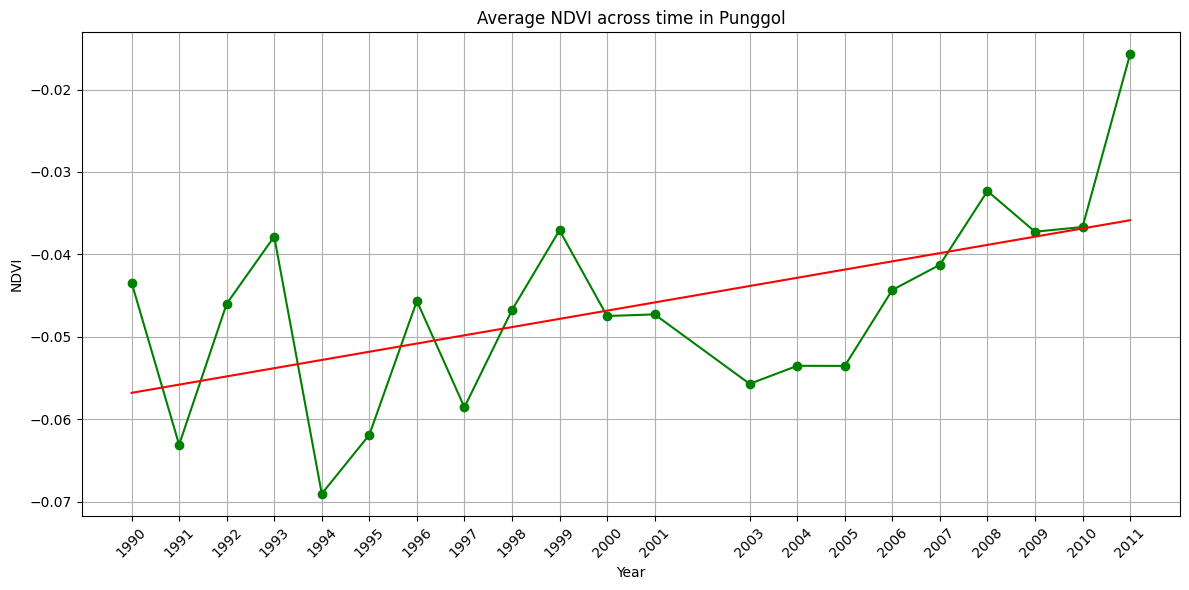

In [183]:
# Filtering for the 'Downtown Core' region
downtown_core_gdf = filtered_gdf[filtered_gdf['region'] == 'DOWNTOWN CORE']

downtown_core_gdf['time'] = pd.to_datetime(downtown_core_gdf['time'])

downtown_core_gdf['year'] = downtown_core_gdf['time'].dt.year

# Group by time and calculate the average temperature
average_temperature = downtown_core_gdf.groupby('year')['NDVI'].mean()

# Plot the average temperature over years
plt.figure(figsize=(12, 6))
average_temperature.plot(kind='line', marker='o', color='g', linestyle='-')

# Fit a line to the averaged data points
# Prepare data for polyfit (fitting a 1-degree polynomial)
x = average_temperature.index.values  # years
y = average_temperature.values
coefficients = np.polyfit(x, y, 1)  # Linear fit
poly = np.poly1d(coefficients)

# Plot the trend line
plt.plot(x, poly(x), color='red', label='Trend Line')
plt.title('Average NDVI across time in Punggol')
plt.xlabel('Year')
plt.ylabel('NDVI')
# plt.ylim(25, 45)
plt.grid(True)
plt.xticks(average_temperature.index, rotation=45)
plt.tight_layout()
plt.show()

#### `region` == PUNGGOL

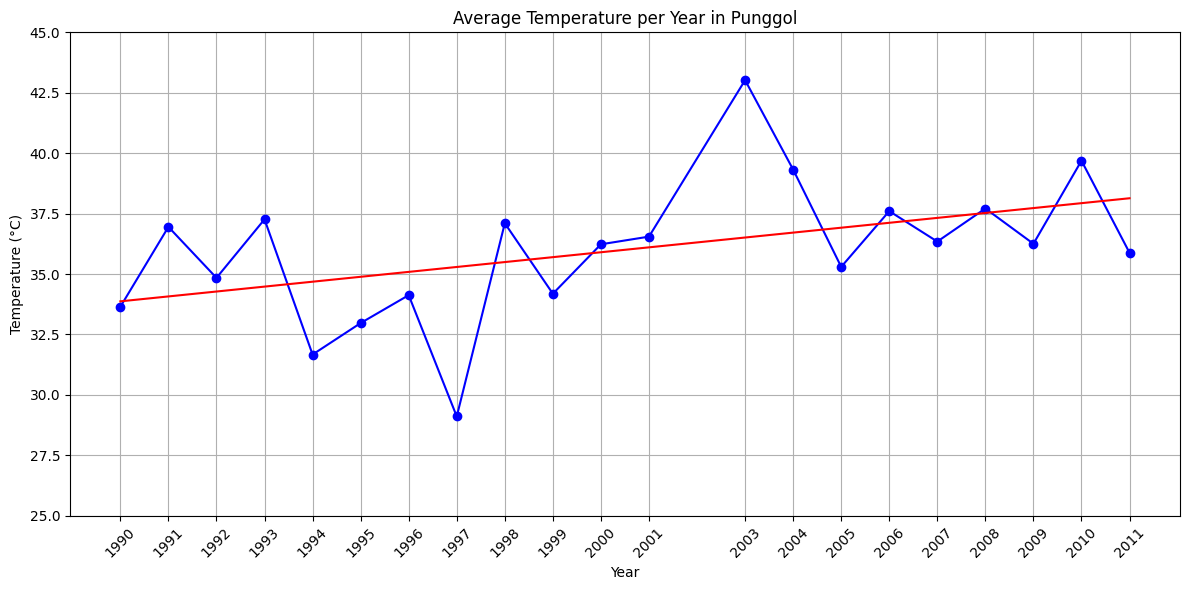

In [178]:
# Filtering for the 'Downtown Core' region
punggol_gdf = filtered_gdf[filtered_gdf['region'] == 'PUNGGOL']

punggol_gdf['time'] = pd.to_datetime(punggol_gdf['time'])

punggol_gdf['year'] = punggol_gdf['time'].dt.year

# Group by time and calculate the average temperature
average_temperature = punggol_gdf.groupby('year')['ST_B6_Celsius'].mean()

# Plot the average temperature over years
plt.figure(figsize=(12, 6))
average_temperature.plot(kind='line', marker='o', color='b', linestyle='-')

# Fit a line to the averaged data points
# Prepare data for polyfit (fitting a 1-degree polynomial)
x = average_temperature.index.values  # years
y = average_temperature.values
coefficients = np.polyfit(x, y, 1)  # Linear fit
poly = np.poly1d(coefficients)

# Plot the trend line
plt.plot(x, poly(x), color='red', label='Trend Line')
plt.title('Average Temperature per Year in Punggol')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.ylim(25, 45)
plt.grid(True)
plt.xticks(average_temperature.index, rotation=45)
plt.tight_layout()
plt.show()

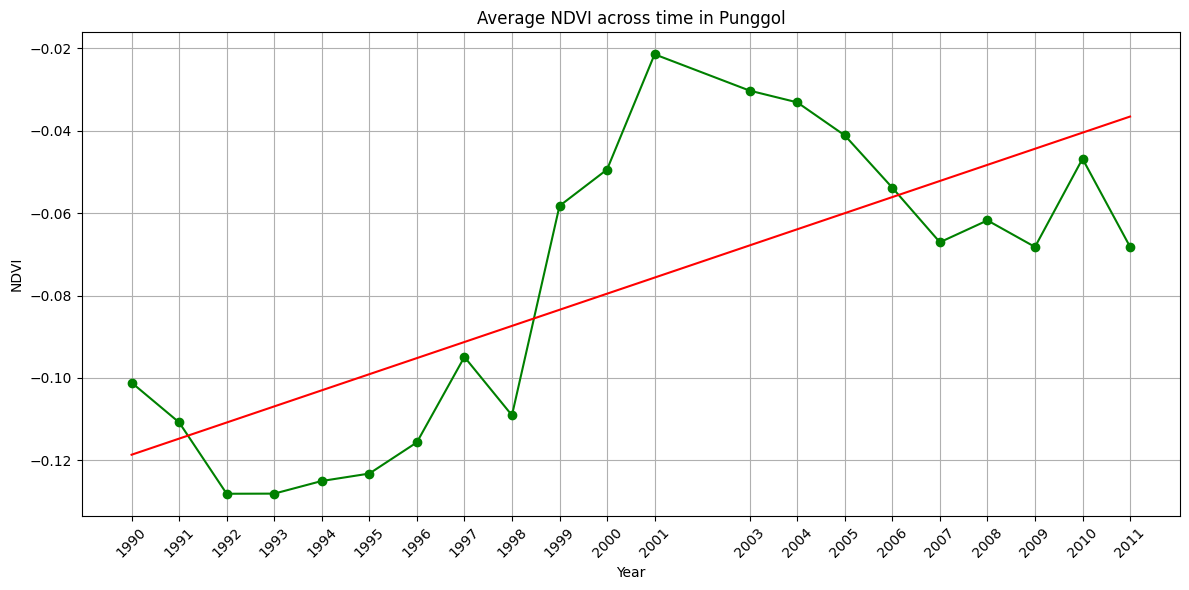

In [182]:
# Filtering for the 'Downtown Core' region
punggol_gdf = filtered_gdf[filtered_gdf['region'] == 'PUNGGOL']

punggol_gdf['time'] = pd.to_datetime(punggol_gdf['time'])

punggol_gdf['year'] = punggol_gdf['time'].dt.year

# Group by time and calculate the average temperature
average_temperature = punggol_gdf.groupby('year')['NDVI'].mean()

# Plot the average temperature over years
plt.figure(figsize=(12, 6))
average_temperature.plot(kind='line', marker='o', color='g', linestyle='-')

# Fit a line to the averaged data points
# Prepare data for polyfit (fitting a 1-degree polynomial)
x = average_temperature.index.values  # years
y = average_temperature.values
coefficients = np.polyfit(x, y, 1)  # Linear fit
poly = np.poly1d(coefficients)

# Plot the trend line
plt.plot(x, poly(x), color='red', label='Trend Line')
plt.title('Average NDVI across time in Punggol')
plt.xlabel('Year')
plt.ylabel('NDVI')
# plt.ylim(25, 45)
plt.grid(True)
plt.xticks(average_temperature.index, rotation=45)
plt.tight_layout()
plt.show()

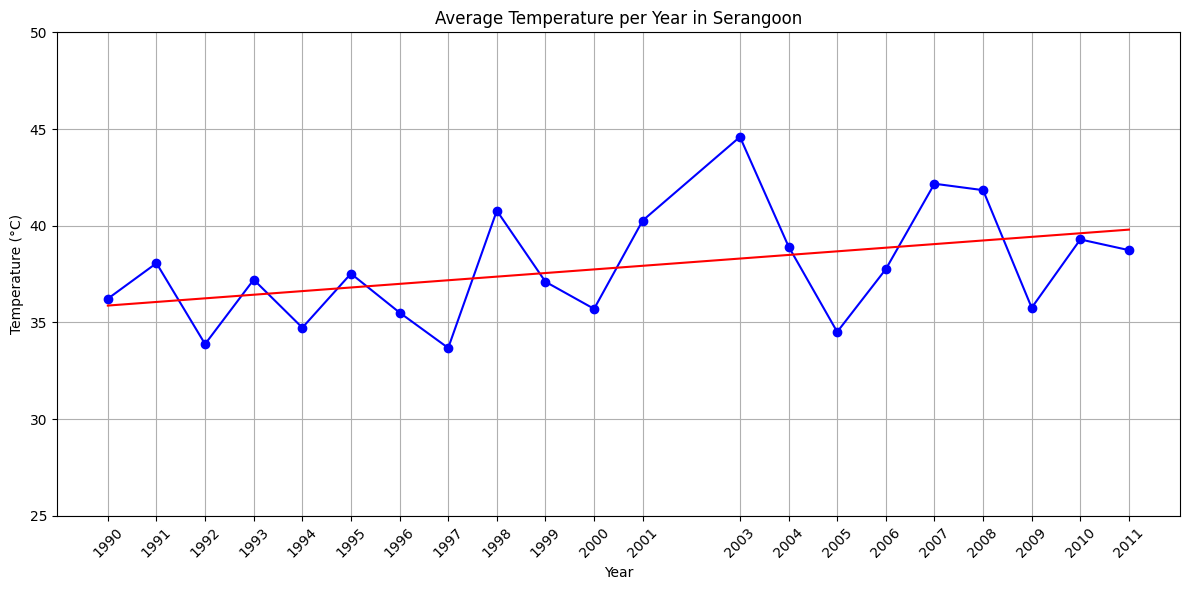

In [174]:
# Filtering for the 'Downtown Core' region
serangoon_gdf = filtered_gdf[filtered_gdf['region'] == 'SERANGOON']

serangoon_gdf['time'] = pd.to_datetime(serangoon_gdf['time'])

serangoon_gdf['year'] = serangoon_gdf['time'].dt.year

# Group by time and calculate the average temperature
average_temperature = serangoon_gdf.groupby('year')['ST_B6_Celsius'].mean()

# Plot the average temperature over years
plt.figure(figsize=(12, 6))
average_temperature.plot(kind='line', marker='o', color='b', linestyle='-')

# Fit a line to the averaged data points
# Prepare data for polyfit (fitting a 1-degree polynomial)
x = average_temperature.index.values  # years
y = average_temperature.values
coefficients = np.polyfit(x, y, 1)  # Linear fit
poly = np.poly1d(coefficients)

# Plot the trend line
plt.plot(x, poly(x), color='red', label='Trend Line')
plt.title('Average Temperature per Year in Serangoon')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.ylim(25, 50)
plt.grid(True)
plt.xticks(average_temperature.index, rotation=45)
plt.tight_layout()
plt.show()

In [175]:
# Assuming 'average_temperature' is your DataFrame with years as the index and average temperatures as the values
# Convert index to DataFrame for regression analysis
serangoon_data = average_temperature.reset_index()
serangoon_data.columns = ['Year', 'Temperature']

# Add a constant term to allow statsmodels to calculate the intercept (necessary for linear regression)
serangoon_data['Intercept'] = 1

# Define the model
model = sm.OLS(serangoon_data['Temperature'], serangoon_data[['Intercept', 'Year']])

# Fit the model
serangoon_results = model.fit()

# Print the summary of the regression
print(serangoon_results.summary())

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     4.193
Date:                Mon, 24 Jun 2024   Prob (F-statistic):             0.0547
Time:                        17:39:25   Log-Likelihood:                -49.715
No. Observations:                  21   AIC:                             103.4
Df Residuals:                      19   BIC:                             105.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -336.2961    182.705     -1.841      0.0

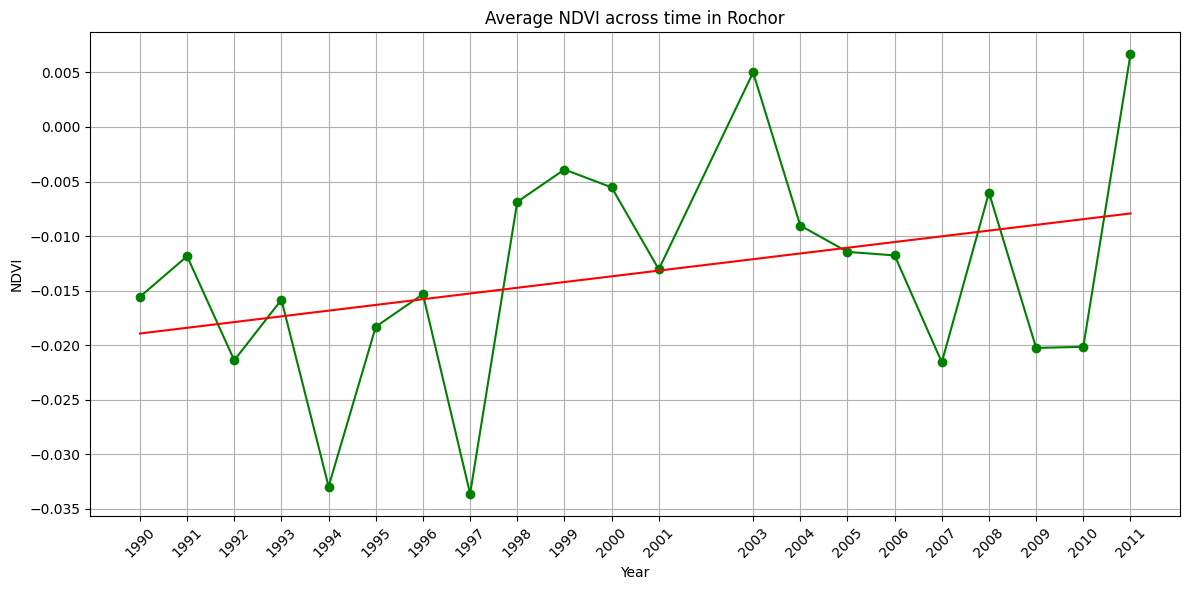

In [185]:
# Filtering for the 'Downtown Core' region
rochor_gdf = filtered_gdf[filtered_gdf['region'] == 'ROCHOR']

rochor_gdf['time'] = pd.to_datetime(rochor_gdf['time'])

rochor_gdf['year'] = rochor_gdf['time'].dt.year

# Group by time and calculate the average temperature
average_temperature = rochor_gdf.groupby('year')['NDVI'].mean()

# Plot the average temperature over years
plt.figure(figsize=(12, 6))
average_temperature.plot(kind='line', marker='o', color='g', linestyle='-')

# Fit a line to the averaged data points
# Prepare data for polyfit (fitting a 1-degree polynomial)
x = average_temperature.index.values  # years
y = average_temperature.values
coefficients = np.polyfit(x, y, 1)  # Linear fit
poly = np.poly1d(coefficients)

# Plot the trend line
plt.plot(x, poly(x), color='red', label='Trend Line')
plt.title('Average NDVI across time in Rochor')
plt.xlabel('Year')
plt.ylabel('NDVI')
# plt.ylim(25, 45)
plt.grid(True)
plt.xticks(average_temperature.index, rotation=45)
plt.tight_layout()
plt.show()